In [1]:
import os
os.chdir('..')
from notebooks import config
import geopandas as gpd
import glob
import h5py
from shapely.geometry import MultiPolygon, box
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from matplotlib import cm
from utils.geotif_io import readTiff
from utils.imgShow import imgShow
from utils.transform_xy import coor2coor
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader


In [2]:
##-----------rgi shp subseting-----------####
# path_rgi13_vec = config.root_proj +'/data/rgi/13_rgi60_CentralAsia/13_rgi60_CentralAsia.shp'
# geodf_rgi13 = gpd.read_file(path_rgi13_vec)
# geodf_rgi13_sel = geodf_rgi13[geodf_rgi13['O2Region'] == '5']
# path_save = config.root +'/data/rgi/13_05_rgi60.shp'
# geodf_rgi13_sel.to_file(path_save)


In [3]:
path_tibet_vec = config.root_proj + '/data/tibet-plateau-boundary/TPBoundary_HF/TPBoundary_HF_wgs84.shp'
path_wkunlun_vec = config.root_proj +'/data/rgi/rgi60_1305_wkunlun/rgi60_1305_wkunlun.shp'
path_dem = config.root_proj + '/data/dem/tandem-x/tandem_wkunlun.tif'
path_img = config.root_proj + '/data/rsimg/l8_kunlun_20200914.tif'


In [4]:
geodf_tibet = gpd.read_file(path_tibet_vec)
geodf_wkunlun = gpd.read_file(path_wkunlun_vec)
rs_img, rs_img_info = readTiff(path_img)
img_srtm, img_srtm_info = readTiff(path_dem)
# height_alt06 = dd.read_csv(alt06_dir+'/*.csv')
# convert dask.dataframe to np.array
# height_array = height_alt06.values.compute()



In [5]:
## region bounds
polygons = [ p for p in geodf_wkunlun['geometry']]
multipolygon = unary_union(polygons)
bounds = multipolygon.bounds
print(bounds)
region_x = (bounds[0], bounds[2], bounds[2], bounds[0], bounds[0])
region_y = (bounds[1], bounds[1], bounds[3], bounds[3], bounds[1])


(80.29637143900004, 35.116839637000055, 81.78115929100005, 35.63781452100005)


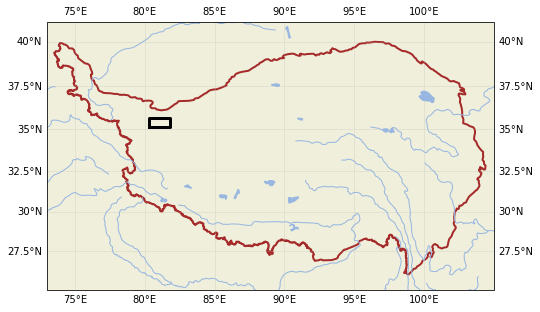

In [35]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=88.5))
ax.set_extent([73, 105, 25.0, 40.0])
## 1. tibet boundary
shp_fea = cfeature.ShapelyFeature(Reader(path_tibet_vec).geometries(), \
                            crs=ccrs.PlateCarree(), edgecolor='Brown', linewidth=2, facecolor='none')
ax.add_feature(shp_fea, zorder=0)
# ax.stock_img()        # add basemap
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.4, zorder=1)
## 2. study region 
plt.plot(region_x, region_y, transform=ccrs.PlateCarree(), linewidth=3, color='black')



number of glaciers: 449


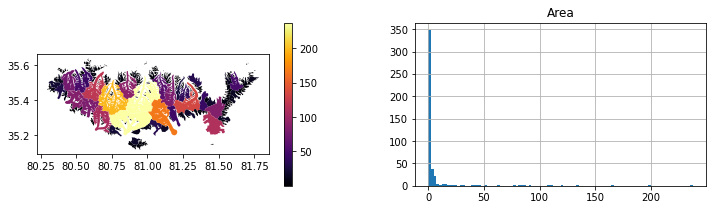

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))
geodf_wkunlun.plot('Area', ax=ax[0], markersize=1,\
                            cmap='inferno', legend=True);
hist = geodf_wkunlun.hist(ax=ax[1], column='Area', bins=100)
print('number of glaciers:', len(geodf_wkunlun))


number of glaciers(area>2): 114


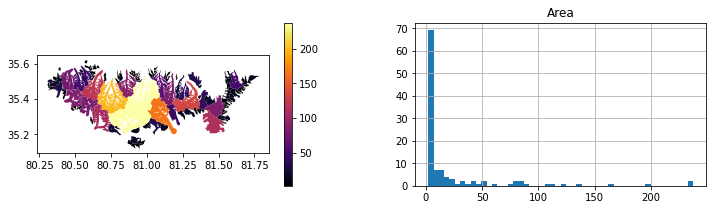

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))
geodf_wkunlun_ = geodf_wkunlun[geodf_wkunlun['Area']>2]
geodf_wkunlun_.plot('Area', ax=ax[0], markersize=1,\
                                cmap='inferno', legend=True);
hist = geodf_wkunlun_.hist(ax=ax[1], column='Area', bins=50)
print('number of glaciers(area>2):', len(geodf_wkunlun_))


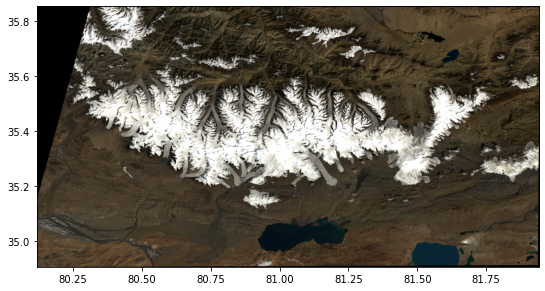

In [16]:
## show remote sensing image
## convert utm coords to wgs84 coords
lon1,lon2,lat1,lat2  = rs_img_info['geoextent']
lon_wgs84, lat_wgs84 = coor2coor(srs_from=rs_img_info['geosrs'], srs_to=4326, x=[lon1,lon2], y=[lat1,lat2])
extent_wgs84 = lon_wgs84 + lat_wgs84

plt.figure(figsize=(9, 9))
imgShow(rs_img, extent = extent_wgs84, \
                color_bands=(2, 1, 0), clip_percent=5)


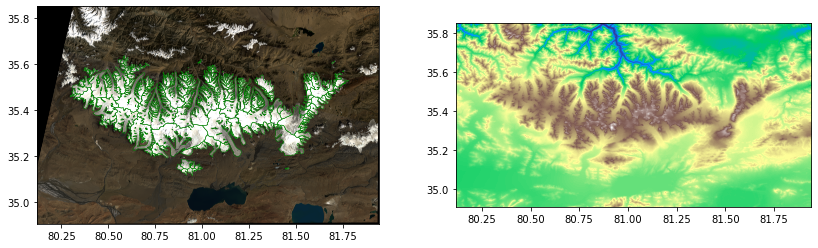

In [32]:
### show dem/rgi_data
plt.figure(figsize=(14, 4))
ax1 = plt.subplot(1,2,1)
imgShow(rs_img, extent = extent_wgs84, \
                color_bands=(2, 1, 0), clip_percent=5)
# geodf_wkunlun.plot('Area', ax=ax1, markersize=1, \
#                             edgecolor='green', label='glacier')
geodf_wkunlun.plot(ax=ax1, linewidth=0.5, color='none',\
                              edgecolor='green', label='glacier')
ax2 = plt.subplot(1,2,2)
plt.imshow(img_srtm, extent=img_srtm_info['geoextent'], \
                            vmin=4000, vmax=7000, cmap='terrain')



<KeysViewHDF5 ['beam_type', 'cycle', 'h_elv', 'lat', 'lon', 'rgt', 'spot', 't_year']>


<Figure size 576x576 with 0 Axes>

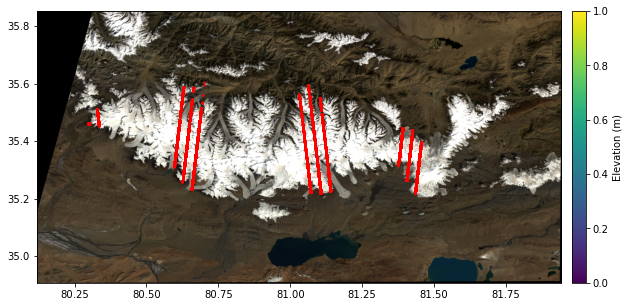

In [18]:
### atl03 
plt.figure(figsize=[8, 8])
with h5py.File('data/icesat2/processed_atl03/atl03_202001_subs.h5','r') as f_a:
    lat_atl03_202001   = f_a['lat'][:]
    lon_atl03_202001   = f_a['lon'][:]
    h_elv_atl03_202001 = f_a['h_elv'][:]
    print(f_a.keys())
x_atl03_202001, y_atl03_202001 = coor2coor(srs_from=4326, \
                        srs_to=rs_img_info['geosrs'], x=lon_atl03_202001, y=lat_atl03_202001)

## show
plt.figure(figsize=(10,5))
imgShow(rs_img, extent=rs_img_info['geoextent'], \
                    color_bands=(2, 1, 0), clip_percent=5)
plt.scatter(x=x_atl03_202001, y=y_atl03_202001, s=1, c='red')
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')


<KeysViewHDF5 ['beam_type', 'cycle', 'h_elv', 'h_tandem', 'lat', 'lon', 'quality_summary', 'rgt', 'spot', 't_year']>


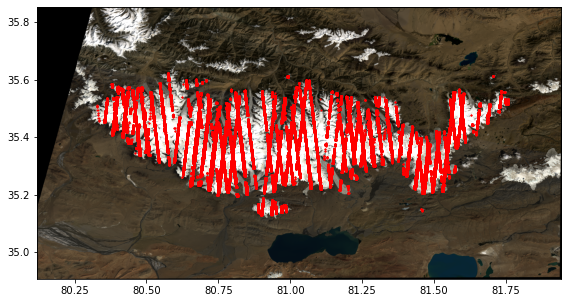

In [19]:
### atl06 data, one month
with h5py.File('data/icesat2/processed_atl06/atl06_2020_subs.h5','r') as f_a:
    lat_atl06_2020   = f_a['lat'][:]
    lon_atl06_2020   = f_a['lon'][:]
    h_elv_atl06_2020 = f_a['h_elv'][:]
    quality_atl06_2020 = f_a['quality_summary'][:]
    print(f_a.keys())
x_atl06_2020, y_atl06_2020 = coor2coor(srs_from=4326, srs_to=rs_img_info['geosrs'], \
                                                            x=lon_atl06_2020, y=lat_atl06_2020)

plt.figure(figsize=(10,5))
imgShow(rs_img, extent=rs_img_info['geoextent'], \
                    color_bands=(2, 1, 0), clip_percent=5)
plt.scatter(x=x_atl06_2020, y=y_atl06_2020, s=1, c='red')


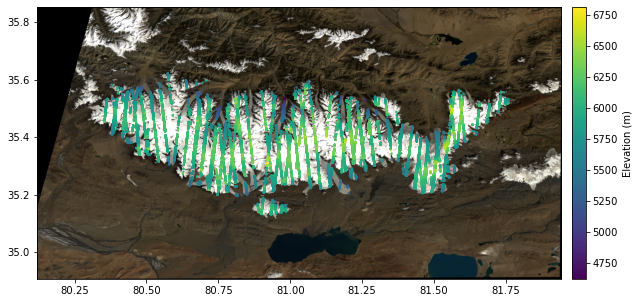

In [20]:
plt.figure(figsize=(10,5))
good = quality_atl06_2020==0
imgShow(rs_img, extent=rs_img_info['geoextent'], \
                      color_bands=(2, 1, 0), clip_percent=5)
plt.scatter(x=x_atl06_2020[good], y=y_atl06_2020[good], s=1, c=h_elv_atl06_2020[good])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
